# Link prediction with Heterogeneous GraphSAGE (HinSAGE)

## Importing and Setup the Environment

In [1]:
import pandas as pd
import numpy as np
import ast
import stellargraph as sg
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from ast import literal_eval
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, top_k_accuracy_score, dcg_score, ndcg_score
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from keras import Model, optimizers, losses, metrics

%matplotlib inline

2022-07-19 16:22:01.827958: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-19 16:22:04.122609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-19 16:22:04.176066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-19 16:22:04.176097: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.

Setup CUDA

In [2]:
tf.config.list_physical_devices('GPU')
sys_details = tf.sysconfig.get_build_info()
cuda = sys_details["cuda_version"]
cudnn = sys_details["cudnn_version"]
print(cuda, cudnn)

11.2 8


In [3]:
batch_size = 300 # Number of user-business links per minibatch
epochs = 400

# Use 70% of edges for training, the rest for testing
train_size = 0.7
test_size = 0.3

## Dataset engineering

In [4]:
item = pd.read_csv("dataset/Item_features/yelp_Item_features.csv")
user = pd.read_csv("dataset/User_features/yelp_UserFeatures.csv")
user_item = pd.read_csv("dataset/User-Item_Interaction/yelp_UserItem_Interaction.csv")

### Working wth the Business

<AxesSubplot:>

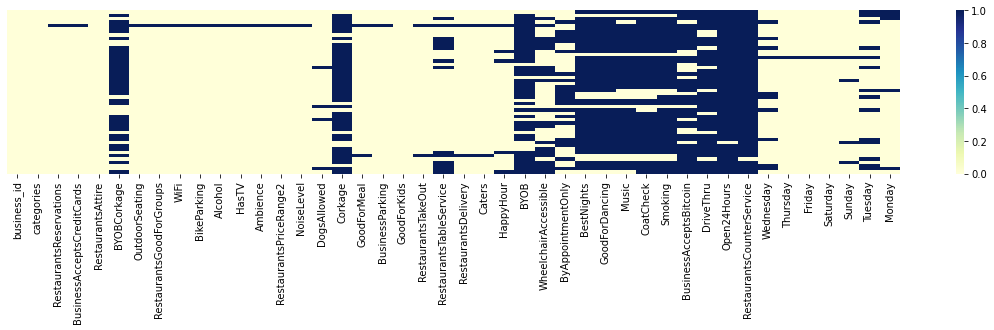

In [5]:
# Sort to define the order of nodes
sorted_df = item.sort_values(by="business_id").set_index("business_id")

# Map IDs to start from 0
sorted_df = sorted_df.reset_index(drop=False)
business_id_mapping = sorted_df["business_id"]

# Normalize the attributes of business
def only_dict(d):
    '''
    Convert json string representation of dictionary to a python dict
    '''
    return ast.literal_eval(d)

def list_of_dicts(ld):
    '''
    Create a mapping of the tuples formed after 
    converting json strings of list to a python list   
    '''
    return dict([(list(d.values())[1], list(d.values())[0]) for d in ast.literal_eval(ld)])

attributes = pd.json_normalize(sorted_df['attributes'].apply(only_dict).tolist())
hours = pd.json_normalize(sorted_df['hours'].apply(only_dict).tolist())
business_features = sorted_df[['business_id', 'categories']].join([attributes,hours])

# Plotting Business features
plt.figure(figsize=(20, 3))
sns.heatmap(business_features.isnull(), cbar=True, yticklabels=False, cmap='YlGnBu')

#### Cleaning and fixing the data

<AxesSubplot:>

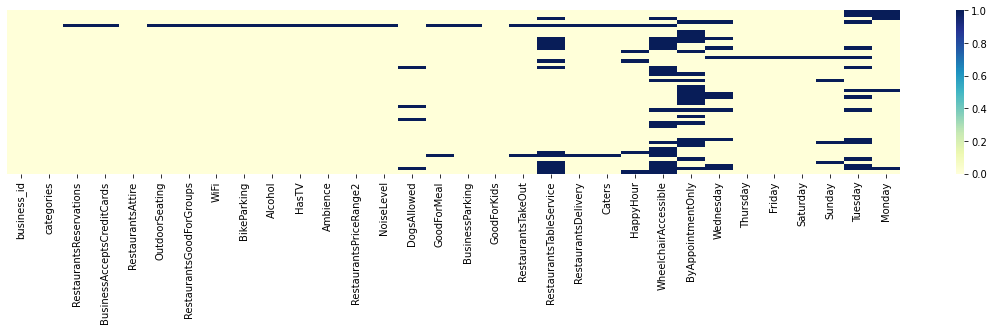

In [6]:
# Cleaning the features removing useless columns
# Because looking at the upper plot we can see how these columns are full of Missing Values 
# that are impossible to correct and manage with the mean or most popular value or other techniques
business_features = business_features.drop(columns=['BYOBCorkage', 'Corkage', 'CoatCheck', 'BYOB', 'DriveThru', 'BusinessAcceptsBitcoin', 'GoodForDancing', 'Smoking', 'BestNights', 'Music', 'Open24Hours',
       'RestaurantsCounterService'])

# Plotting Business features without bad coloumns
plt.figure(figsize=(20, 3))
sns.heatmap(business_features.isnull(), cbar=True, yticklabels=False, cmap='YlGnBu')

In [7]:
# Fixing Missing Value on Restaurants Take Out
business_features['RestaurantsTakeOut'] = business_features['RestaurantsTakeOut'].map({'True': True, 'False': False, 'None': np.nan})
print(business_features['RestaurantsTakeOut'].value_counts())
x = business_features.RestaurantsTakeOut.value_counts(normalize=True)
print(x)
missing = business_features['RestaurantsTakeOut'].isna()
# I would preserve as many columns as I can, for doing that I decide to use the numpy.random.choice 
# a special function to replace the missing value, in fact, the parameter "p=x.values" is the probabilities associated with each entry,
# in this case, True and False, and during the replacement of the "None" value, is respected the probabilities of True and False
# that we've in the initial state of the data
business_features.loc[missing,'RestaurantsTakeOut'] = np.random.choice(x.index, size=len(business_features[missing]), p=x.values)
print(business_features['RestaurantsTakeOut'].value_counts())

True     33
False     3
Name: RestaurantsTakeOut, dtype: int64
True     0.916667
False    0.083333
Name: RestaurantsTakeOut, dtype: float64
True     46
False     4
Name: RestaurantsTakeOut, dtype: int64


<AxesSubplot:>

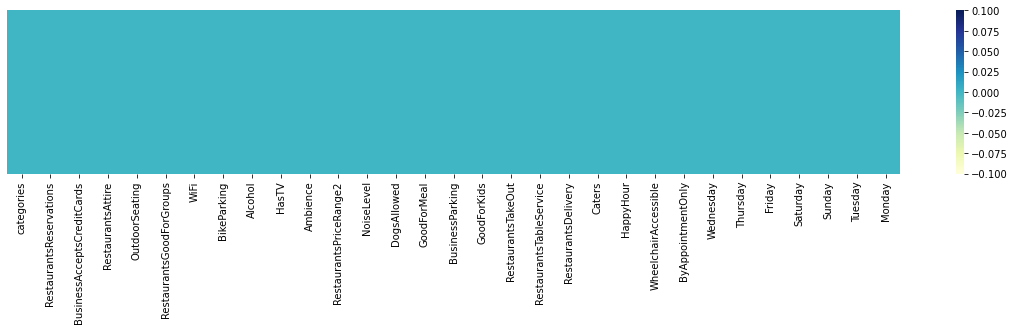

In [8]:
# Generalization of the code to delete all the incompatibility
columns = business_features.columns.drop('business_id')
for column in columns:
    x = business_features.RestaurantsTakeOut.value_counts(normalize=True)
    missing = business_features[column].isna()
    business_features.loc[missing, column] = np.random.choice(x.index, size=len(business_features[missing]), p=x.values)

# Plotting Business features to discover other missing value
business_features = business_features.drop(columns='business_id')
plt.figure(figsize=(20, 3))
sns.heatmap(business_features.isnull(), cbar=True, yticklabels=False, cmap='YlGnBu')

##### Encoding Phase

<AxesSubplot:>

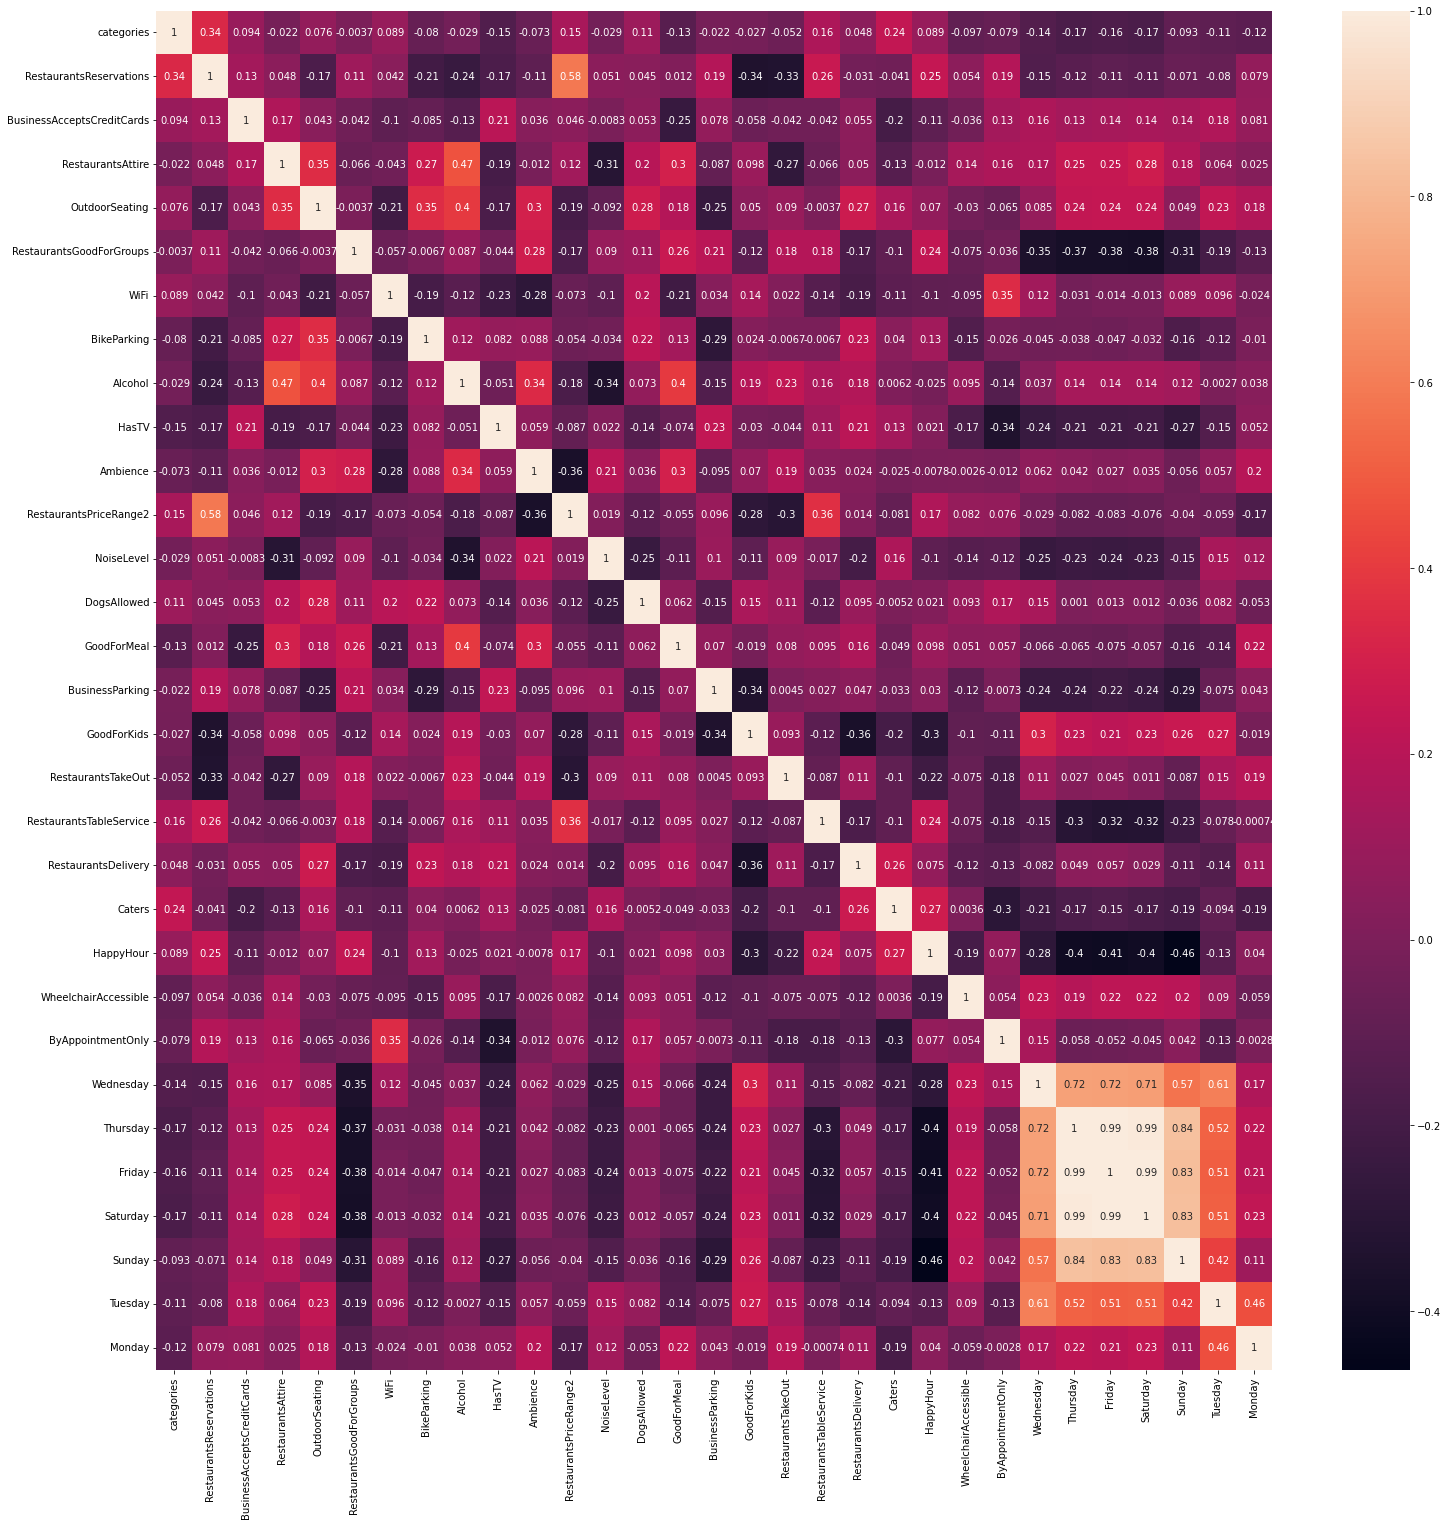

In [9]:
# Using the OrdinalEncoder from SKlearn to encode columns with string values to numbers
enc = OrdinalEncoder()
business_features[['categories', 'RestaurantsTakeOut', 'Alcohol',
       'RestaurantsPriceRange2', 'RestaurantsReservations', 'NoiseLevel',
       'BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups',
       'RestaurantsAttire', 'BikeParking', 'GoodForKids', 'HasTV',
       'DogsAllowed', 'Ambience', 'RestaurantsTableService', 'HappyHour',
       'GoodForMeal', 'Caters', 'OutdoorSeating', 'RestaurantsDelivery',
       'BusinessParking', 'WiFi', 'WheelchairAccessible', 'ByAppointmentOnly',
       'Monday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Tuesday',
       'Wednesday']] = enc.fit_transform(business_features[['categories', 'RestaurantsTakeOut', 'Alcohol',
       'RestaurantsPriceRange2', 'RestaurantsReservations', 'NoiseLevel',
       'BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups',
       'RestaurantsAttire', 'BikeParking', 'GoodForKids', 'HasTV',
       'DogsAllowed', 'Ambience', 'RestaurantsTableService', 'HappyHour',
       'GoodForMeal', 'Caters', 'OutdoorSeating', 'RestaurantsDelivery',
       'BusinessParking', 'WiFi', 'WheelchairAccessible', 'ByAppointmentOnly',
       'Monday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Tuesday',
       'Wednesday']].astype(str))

# Correlation Matrix
_, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(data=business_features.corr(), ax=ax, annot=True)

### Working wth the User

<AxesSubplot:>

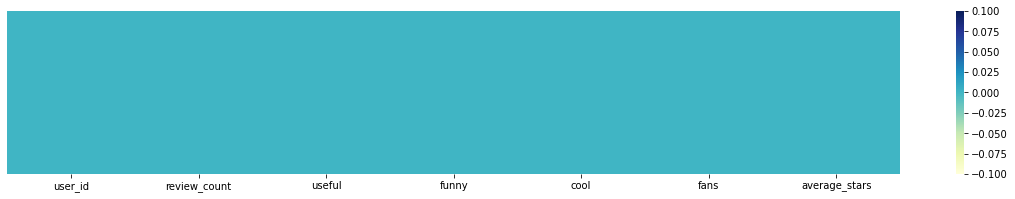

In [10]:
# Removing useless columns
user_features = user.drop(columns=['name','elite', 'yelping_since', 'friends', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'])

# Plot to discover missing value
plt.figure(figsize=(20, 3))
sns.heatmap(user_features.isnull(), cbar=True, yticklabels=False, cmap='YlGnBu')

<AxesSubplot:>

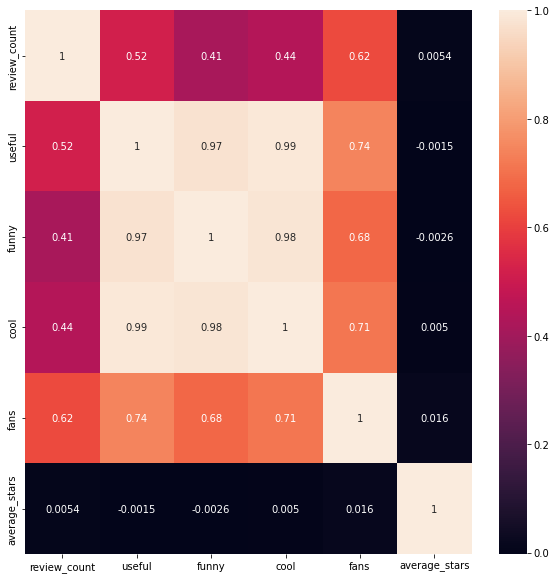

In [11]:
# Remap user ID (to start at 0)
user_features = user_features.reset_index(drop=False)
user_id_mapping = user_features["user_id"]
user_features = user_features[['review_count','useful','funny','cool','fans','average_stars']]

# User Features Correlation Matrix
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=user_features.corr(), ax=ax, annot=True)

<AxesSubplot:>

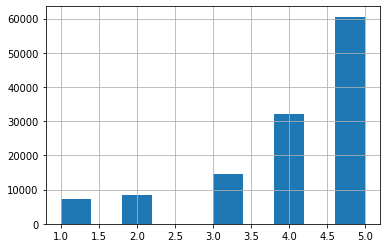

In [12]:
# Plotting the ratings distribution
user_item['stars'].hist()

### Extract the edges
The edges are already implicitly provided by the user-item matrix. The important part however is that we need to use the remappings to align the IDs of the dataframes.

In [13]:
# Removing from user_item all the user_id not in the user, the creation of the subset was based only on the business_id
list_of_user = user['user_id'].unique()
user_item = user_item[user_item['user_id'].isin(list_of_user)] # From 80181 users to 46116 users

print("Before remapping...")
user_item.head()

Before remapping...


review_id                 user_id             business_id  \
4110  zsk2ezJCrXypSE-GtHXGrQ  hcyRBdOhZU1xVKW8Bgoz8w  DcBLYSvOuWcNReolRVr12A   
4112  lfeaphqwCNzZ-R2rtOY0sQ  uycdVh-5ytVRIJEQRyFBwA  DcBLYSvOuWcNReolRVr12A   
4114  VKynIXaY30eSJJWXAfySUA  q0fyCpjfHXC7d7q--LQQfA  DcBLYSvOuWcNReolRVr12A   
4117  EwFiMm-jJ9ST1QZr5W6ykQ  01HpNrCSLNWbQG9Fv3c4Pw  DcBLYSvOuWcNReolRVr12A   
4118  NzDe4gH1p6HlFWBzC0OsKg  a_DzZ8Wtwn7sFhMb7yxLFA  DcBLYSvOuWcNReolRVr12A   

      stars  useful  funny  cool  \
4110      3       1      0     0   
4112      5       0      0     0   
4114      1       1      0     0   
4117      3       0      0     0   
4118      4       0      0     1   

                                                   text                 date  
4110  The food is good. Nothing great or bad about t...  2019-08-20 21:38:07  
4112  We were in town for a wedding and a group of u...  2019-10-13 04:19:53  
4114  Everybody ranting and raving about their char ...  2017-05-11 00:37:01  
4117  It's a convenient location right in the hotel....  2019-02-09 20:11:48  
4118  We put our name down for a table and they said...  2018-07-20 17:18:11

In [14]:
# Business IDs 
business_map = business_id_mapping.reset_index().set_index("business_id").to_dict()
user_item["business_id"] = user_item["business_id"].map(business_map["index"]).astype(int)

# Map user IDs
user_map = user_id_mapping.reset_index().set_index("user_id").to_dict()
user_item["user_id"] = user_item["user_id"].map(user_map["index"]).astype(int)

print("After remapping...")
user_item.head()

After remapping...


review_id  user_id  business_id  stars  useful  funny  \
4110  zsk2ezJCrXypSE-GtHXGrQ     6145           10      3       1      0   
4112  lfeaphqwCNzZ-R2rtOY0sQ     6146           10      5       0      0   
4114  VKynIXaY30eSJJWXAfySUA     6147           10      1       1      0   
4117  EwFiMm-jJ9ST1QZr5W6ykQ        0           10      3       0      0   
4118  NzDe4gH1p6HlFWBzC0OsKg        1           10      4       0      0   

      cool                                               text  \
4110     0  The food is good. Nothing great or bad about t...   
4112     0  We were in town for a wedding and a group of u...   
4114     0  Everybody ranting and raving about their char ...   
4117     0  It's a convenient location right in the hotel....   
4118     1  We put our name down for a table and they said...   

                     date  
4110  2019-08-20 21:38:07  
4112  2019-10-13 04:19:53  
4114  2017-05-11 00:37:01  
4117  2019-02-09 20:11:48  
4118  2018-07-20 17:18:11

In [15]:
# Create the edge dataframe with Source, Target, Weight
square_edges_with_ratings = user_item[["user_id", "business_id", "stars"]].reset_index()
square_edges_with_ratings = square_edges_with_ratings[["user_id", "business_id", "stars"]]
square_edges_with_ratings

user_id  business_id  stars
0         6145           10      3
1         6146           10      5
2         6147           10      1
3            0           10      3
4            1           10      4
...        ...          ...    ...
57713    46004           49      2
57714     9500           49      2
57715    45007           49      2
57716    45008           49      2
57717    45009           49      5

[57718 rows x 3 columns]

## Loading data into StellarGraph from Pandas
Our graph is a heterogeneous graph with features and two types of nodes User and Business, we need to describe the source and target and after they need to be modelles as different dataframe for the features (already done previusly)

We can now use them to create a StellarGraph, but the IDs need to be unique, so we need to add a prefix into the three dataframe

In [16]:
# User Features
user_features_prefix = user_features.set_index("user-" + user_features.index.astype(str)) # ex. user-0
# Business Features
business_features_prefix = business_features.set_index("biz-" + business_features.index.astype(str)) # ex. biz-0

# Edges Dataframe
square_edges_with_ratings_prefix = square_edges_with_ratings
for user_value in square_edges_with_ratings_prefix.user_id.values:
    square_edges_with_ratings_prefix['user_id'] = square_edges_with_ratings_prefix['user_id'].replace(user_value, "user-"+str(user_value))
for business_value in square_edges_with_ratings_prefix.business_id.values:
    square_edges_with_ratings_prefix['business_id'] = square_edges_with_ratings_prefix['business_id'].replace(business_value, "biz-"+str(business_value))
# Raname Edge coloumn in source, target and weight
square_edges_with_ratings_prefix.rename(columns = {'user_id':'source', 'business_id':'target', 'stars':'weight'}, inplace=True)

# Create the Graph G
G = sg.StellarGraph({"user": user_features_prefix, "business": business_features_prefix}, square_edges_with_ratings_prefix)

# Edge dataframe to original coloumn name
square_edges_with_ratings_prefix.rename(columns = {'source':'user_id', 'target':'business_id', 'weight':'stars'}, inplace=True)

# Show the created Graph structure
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 46166, Edges: 57718

 Node types:
  user: [46116]
    Features: float32 vector, length 6
    Edge types: user-default->business
  business: [50]
    Features: float32 vector, length 31
    Edge types: business-default->user

 Edge types:
    business-default->user: [57718]
        Weights: range=[1, 5], mean=4.04796, std=1.29419
        Features: none


Split the edges into train and test sets for model training/evaluation

Task is a supervised Link prediction: 
- Given a graph of user-business ratings:
    - train the model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. 
- The model requires the user-business graph structure, to do the neighbour sampling required by the HinSAGE algorithm.

In [17]:
edges_train, edges_test = model_selection.train_test_split(
    square_edges_with_ratings_prefix, train_size=train_size, test_size=test_size,
    random_state=42, stratify=square_edges_with_ratings_prefix['stars']
)

edgelist_train = list(edges_train[["user_id", "business_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["user_id", "business_id"]].itertuples(index=False))

labels_train = edges_train["stars"]
labels_test = edges_test["stars"]

edgelist_train_df = pd.DataFrame(edgelist_train, columns=['user_id','business_id'])
edgelist_test_df = pd.DataFrame(edgelist_test, columns=['user_id','business_id'])

`num_samples` specify the sizes of first-hop and second-hop neighbour samples for HinSAGE, his length defines the number of layers in the HinSAGE model.

In [18]:
num_samples = [8, 4] # Number of neighbors to sample per layer -> 8, 4 it's the best based on speed and results of the training

Create the generators to feed data from the graph to the Keras model. We need to specify the nodes types pairs that we will feed to the model.

In [19]:
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=("user", "business"), seed=42
)

train_gen = generator.flow(edgelist_train, labels_train, shuffle=True, seed=42) # Shuffle to improve training
test_gen = generator.flow(edgelist_test, labels_test, seed=42)

The architecture of the model: Two-layer of HinSAGE model and a link regression layer.

First, define the HinSAGE part of the model, with hidden layer sizes of 32 for both HinSAGE layers, a bias term, and no dropout.

OBS: layer_sizes must be equal to the length of num_samples, len(num_samples) defines the number of hops (layers) in the HinSAGE model.

In [20]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('business', [3]),
 ('business', [4]),
 ('user', [5]),
 ('user', []),
 ('business', [])]

In [21]:
generator.schema.schema

{'business': [EdgeType(n1='business', rel='default', n2='user')],
 'user': [EdgeType(n1='user', rel='default', n2='business')]}

## Create the model

In [79]:
hinsage_layer_sizes = [32, 32] # Tried differend config, Best results with 32x32
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
) # Best dropout 0.0

# Expose input and output sockets of hinsage
x_inp, x_out = hinsage.in_out_tensors()

Add the final estimator layer for predicting the ratings. The `edge_embedding_method` argument specifies the way in which node embeddings are combined into link representations (links represent user-business ratings). We will use `concat`, node embeddings are concatenated to get link embeddings.

In [80]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [81]:
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4), # Tested 1e-2, 1e-3, 1e-4 -> Best 1e-4
    loss=losses.mean_squared_error, # Best loss for training this model
    metrics=[root_mean_square_error, metrics.mae],
)

# Model Summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8, 31)]      0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 32, 6)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 32, 31)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1, 6)]       0           []                               
                                                                                            

Evaluate the fresh (untrained) model on the test set (for reference):

In [82]:
# Specify the number of workers to use for model training
num_workers = 4

test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

train_metrics = model.evaluate(
    train_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

135/135 [==============================] - 14s 98ms/step - loss: 18.3088 - root_mean_square_error: 4.2789 - mean_absolute_error: 4.0760

Train Set Metrics of the initial (untrained) model:
	loss: 18.3088
	root_mean_square_error: 4.2789
	mean_absolute_error: 4.0760

Test Set Metrics of the initial (untrained) model:
	loss: 18.3309
	root_mean_square_error: 4.2810
	mean_absolute_error: 4.0786


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [83]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/400
135/135 [==============================] - 22s 153ms/step - loss: 16.3906 - root_mean_square_error: 4.0455 - mean_absolute_error: 3.8319 - val_loss: 14.5767 - val_root_mean_square_error: 3.8175 - val_mean_absolute_error: 3.5907
Epoch 2/400
135/135 [==============================] - 21s 149ms/step - loss: 12.9963 - root_mean_square_error: 3.6016 - mean_absolute_error: 3.3616 - val_loss: 11.5253 - val_root_mean_square_error: 3.3944 - val_mean_absolute_error: 3.1389
Epoch 3/400
135/135 [==============================] - 21s 150ms/step - loss: 10.2547 - root_mean_square_error: 3.1996 - mean_absolute_error: 2.9514 - val_loss: 9.0920 - val_root_mean_square_error: 3.0148 - val_mean_absolute_error: 2.7796
Epoch 4/400
135/135 [==============================] - 21s 150ms/step - loss: 8.1460 - root_mean_square_error: 2.8521 - mean_absolute_error: 2.6286 - val_loss: 7.3045 - val_root_mean_square_error: 2.7022 - val_mean_absolute_error: 2.4873
Epoch 5/400
135/135 [======================

Plot the training history:

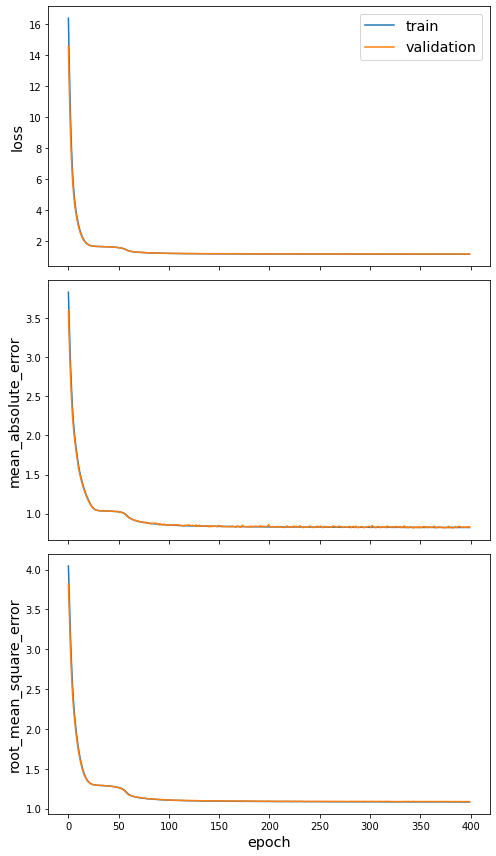

In [84]:
sg.utils.plot_history(history)

Evaluate the trained model on test user-business rankings:

In [111]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

58/58 [==============================] - 6s 89ms/step - loss: 1.1842 - root_mean_square_error: 1.0870 - mean_absolute_error: 0.8284
Test Evaluation:
	loss: 1.1842
	root_mean_square_error: 1.0870
	mean_absolute_error: 0.8284


Compare the predicted test rankings with "mean baseline" rankings, to see how much better our model does compared to this (very simplistic) baseline:

In [112]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean business ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

58/58 [==============================] - 5s 85ms/step
Mean Baseline Test set metrics:
	root_mean_square_error =  1.294122506620007
	mean_absolute_error =  1.0260586318916856

Model Test set metrics:
	root_mean_square_error =  1.0895833026259634
	mean_absolute_error =  0.8299923407636303


Compare the distributions of predicted and true rankings for the test set:

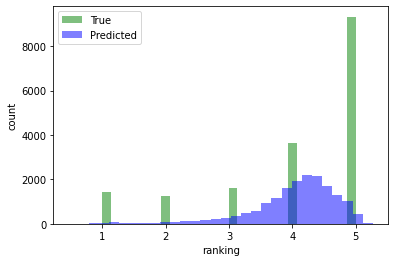

In [87]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

Note: the distribution of predicted scores is still very narrow, and rarely gives 1, 2 or 5 as a score.

This algorithm learns to predict company ratings by using a user-business graph. It can be improved further by utilizing other relationships, such as user friendships, if they become available.
The best thing is that the model's core method does not need to alter at all to account for these additional relations - all that changes is the graph from which it learns!

In [88]:
model.save('/home/lerwey/GNNThesis/saved_model_400epoch_stratified')

INFO:tensorflow:Assets written to: /home/lerwey/GNNThesis/saved_model_400epoch_stratified/assets


In [22]:
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))
model400 = keras.models.load_model('/home/lerwey/GNNThesis/saved_model_400epoch_stratified', custom_objects={'root_mean_square_error':root_mean_square_error})

## Creating from an Heterogeneus graph an Homogeneus subgraph for ranking the best Path for an User

In these example we'll use the user-4032 for testing the algorithm, having in total 9 biz rating in the dataset

In [108]:
# Given an user_x generate all the business rating prediction
def generate_business_graph(user_id, model):
    user_ratings = pd.DataFrame(columns=['user_id', 'business_id'])
    for i in range(0,50):
        user_ratings.loc[i] = [user_id, 'biz-'+str(i)]
    user_ratings_list  = list(user_ratings[["user_id", "business_id"]].itertuples(index=False))
    user_ratings_gen = generator.flow(user_ratings_list)
    predict = model.predict(user_ratings_gen)
    user_predict_ratings = user_ratings
    user_predict_ratings['ratings'] = predict
    business_graph = pd.concat([user_predict_ratings[['business_id','ratings']], item[['latitude','longitude','review_count']]], axis=1)
    return business_graph, user_predict_ratings

# Using NetworkX for plotting a graph
def plot_graph(user_predict_ratings, fig_size, source, target, edge):
    G = nx.from_pandas_edgelist(user_predict_ratings, source, target, edge_attr=edge)
    ratings = [i[edge] for i in dict(G.edges).values()]
    labels = [i for i in dict(G.nodes).keys()]
    labels = {i:i for i in dict(G.nodes).keys()}

    fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax = ax)
    nx.draw_networkx_edges(G, pos, width=ratings, ax=ax)
    _ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

1/1 [==============================] - 0s 45ms/step


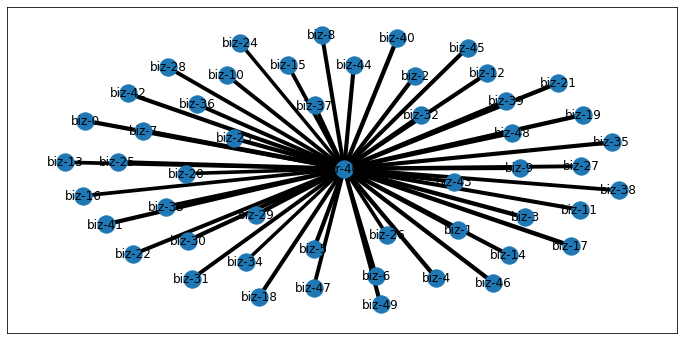

In [109]:
# Generating the user_4032-Biz graph with ratings
business_graph_user4032, user_4032_predict_ratings = generate_business_graph('user-4032', model400)
# Plotting User-Business Graph
plot_graph(user_4032_predict_ratings, [12,6], 'user_id', 'business_id', 'ratings')

### Creating the biz-biz graph with self computed weight
- Weight = distance_between_biz + AVG(rating)*(review_count_1+review_count_2)*0.0001

Into the final the graph each weighted links are normilized (0,1)

In [92]:
# Calculating the distance between two points using the Haversine Distance
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

# Generate the weighted homogeneous graph using the weight formula
def weighted_business_graph(business_graph_user_x):
    business_graph_weight = pd.DataFrame(columns=['S_business_id','T_business_id','Weight'])
    for start_row in business_graph_user_x.itertuples(index=False):
        for end_row in business_graph_user_x.itertuples(index=False):
            if(start_row.business_id != end_row.business_id):
                distances_km = haversine_distance(start_row.latitude, start_row.latitude, end_row.latitude, end_row.longitude)
                Popular_AVG_ratings = ((start_row.ratings+end_row.ratings)/2)*((start_row.review_count+end_row.review_count)*0.0001)
                df = {'S_business_id': start_row.business_id, 'T_business_id': end_row.business_id, 'Weight': Popular_AVG_ratings}
                business_graph_weight = business_graph_weight.append(df, ignore_index = True)
    return business_graph_weight

# Normalize the graph weight
def normalize_graph_weight(weighted_business_graph):
    scaler = MinMaxScaler()
    scaler.fit(weighted_business_graph[['Weight']])
    weighted_business_graph['Weight'] = scaler.transform(weighted_business_graph[['Weight']])
    return weighted_business_graph

### Find The Heaviest Path
Having calculated the weights between the two businesses such as the quality in moving from one POI to the next among all those present, in the path calculation I have to find that path that maximizes the weights between all the connections

In [93]:
# Seach for the heaviest path with lenght 4 (cutoff=4)
def find_heaviest_path(business_graph_weight, userID):
        # Create Graph
        G = nx.from_pandas_edgelist(business_graph_weight,'S_business_id','T_business_id', edge_attr='Weight')
        weight = [i['Weight'] for i in dict(G.edges).values()]
        labels = [i for i in dict(G.nodes).keys()]
        labels = {i:i for i in dict(G.nodes).keys()}
        # Search for the Maximum Path
        heaviest_user_path = pd.DataFrame(columns=['userID','Path'])
        for row in business_graph_weight.itertuples(index=False):
                # cutoff for now fixed, typically depend on the time avaiable for the trip
                heaviest_path = max((path for path in nx.all_simple_paths(G, source=row.S_business_id, target=row.T_business_id, cutoff=4)),
                        key=lambda path: nx.path_weight(G, path, weight='Weight'))
                df = {'userID': userID, 'Path': heaviest_path}
                heaviest_user_path = heaviest_user_path.append(df, ignore_index = True)
        return heaviest_user_path

# All-in function for searching the heaviest path
def search_path(userID):
    # Create Business graph
    business_graph_user, user_predict_ratings = generate_business_graph(userID, model400)
    # Drop the Biz used in the training set
    temp_x = -1
    for x in edgelist_train_df[edgelist_train_df['user_id'] == userID]['business_id']:
        if x != temp_x:
            business_graph_user = business_graph_user.drop([int(x.lstrip("biz-"))]) #Training Biz
        temp_x = x
    # Compute the heaviest_path
    business_graph_user_weight = weighted_business_graph(business_graph_user)
    business_graph_user_weight = normalize_graph_weight(business_graph_user_weight)
    heaviest_user_path = find_heaviest_path(business_graph_user_weight, userID)
    return heaviest_user_path, user_predict_ratings, business_graph_user_weight

In [94]:
'''
1. Creating the Homogeneus biz-to-biz graph
2. Removing all the biz used in the training phase
3. Computing the heaviest path
'''
heaviest_user_4032_path, user_4032_predict_ratings, business_graph_user_4032_weight = search_path('user-4032')
user_4032_predict_ratings.to_csv('dataset/user_4032_predict_ratings.csv', index=False)
heaviest_user_4032_path.to_csv('dataset/heaviest_user_4032_path.csv', index=False)
business_graph_user_4032_weight.to_csv('dataset/business_graph_user_4032_weight.csv', index=False)

1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_651/1610325334.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  business_graph_weight = business_graph_weight.append(df, ignore_index = True)
/tmp/ipykernel_651/1610325334.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  business_graph_weight = business_graph_weight.append(df, ignore_index = True)
/tmp/ipykernel_651/1610325334.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  business_graph_weight = business_graph_weight.append(df, ignore_index = True)
/tmp/ipykernel_651/1610325334.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  business_graph_weight = business_graph_weight.append(df, ignore_index = True)


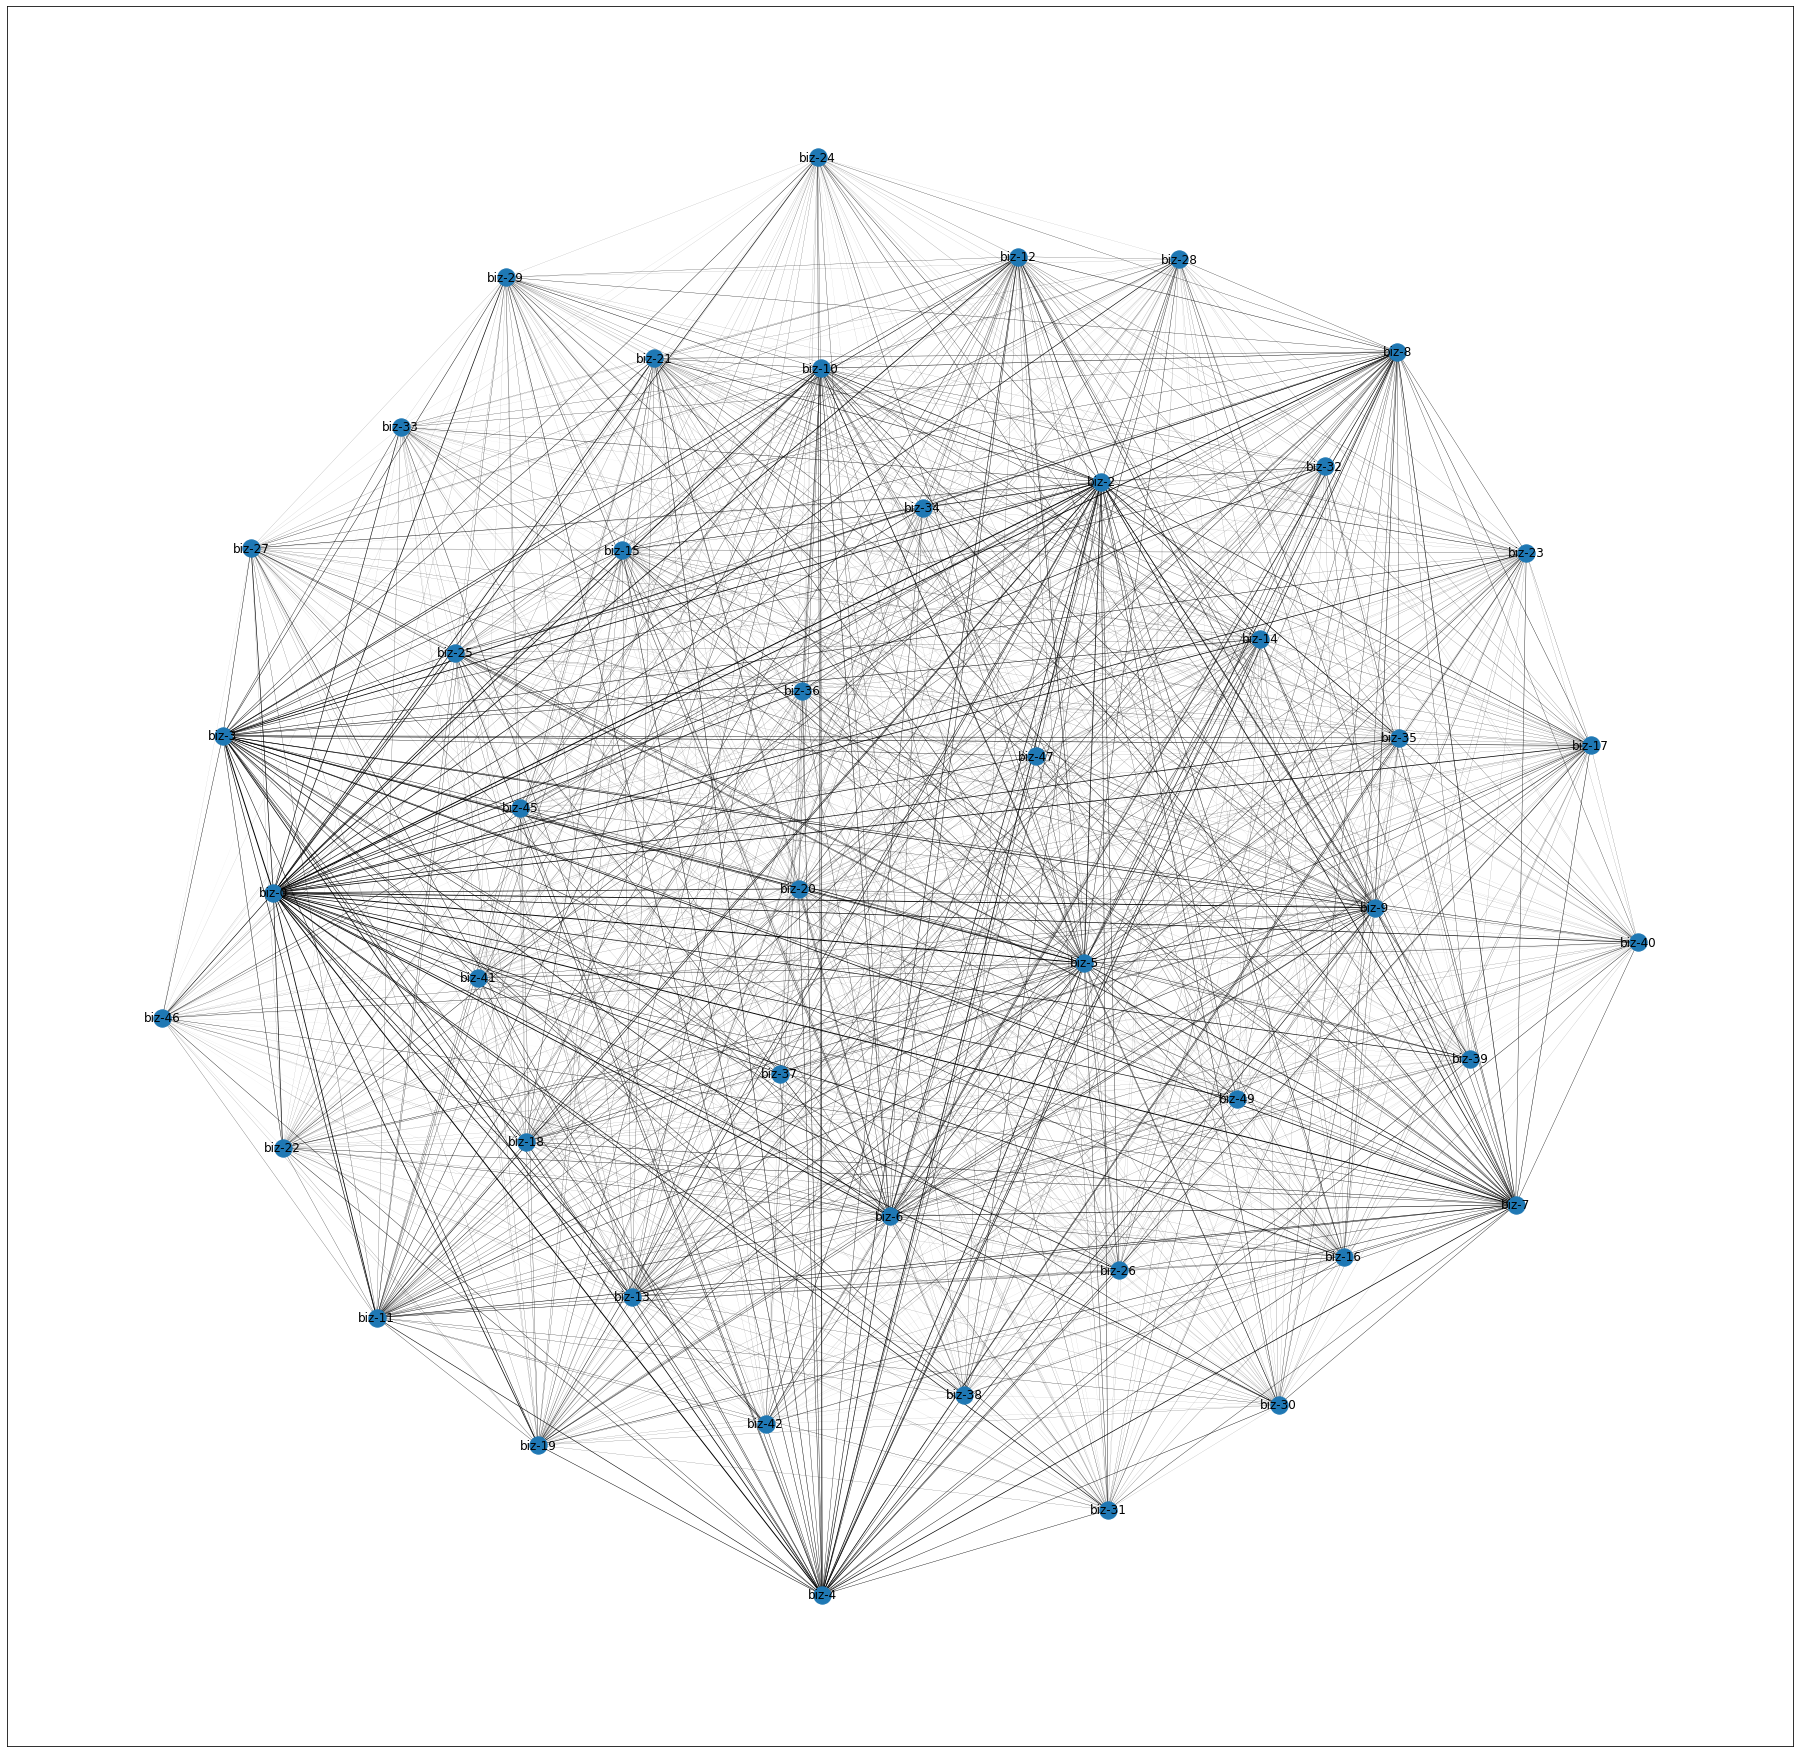

In [110]:
# Plotting Business-Business Graph
plot_graph(business_graph_user_4032_weight, [32,32], 'S_business_id','T_business_id', 'Weight')

In [96]:
# Reading computation from files
user_4032_predict_ratings = pd.read_csv('dataset/user_4032_predict_ratings.csv')
heaviest_user_4032_path = pd.read_csv('dataset/heaviest_user_4032_path.csv')
heaviest_user_4032_path['Path'] = heaviest_user_4032_path['Path'].apply(literal_eval)

### Ranking the path
Two type of ranking:
- Global ranking to find the best path in all the combination
- Local ranking to find the best path based on the starting point of the user

Rank = num_of_biz_in_the_target_split + (-position_of_the_biz_in_the_path*0.1) + (predicted_rank*0.1) -> Higher == Best Reccomendation

    - num_of_biz_in_the_target_split _> The more biz of the target_set I have in the path, the better the recommended path will be
    - -position_of_the_biz_in_the_path*0.1 _> If the position of the biz in the path is early, this will be a better rec
    - predicted_rank*0.1 _> The higher the total sum of the ratings in the path, the better the recommendation will be

In [97]:
# Ranking algorithm for the path
def ranking(userID, heaviest_user_path, user_predict_ratings):
    target_biz = edgelist_test_df[edgelist_test_df['user_id'] == userID]['business_id'].to_numpy()
    rank_series = np.array([], dtype=int)
    for path in heaviest_user_path['Path']:
        rank = 0
        for i in range(0, len(path)-1):
            for j in range (0, len(target_biz)-1):
                if path[i] == target_biz[j]:
                    rank = (rank + 1) + (-(i*0.1)) + (user_predict_ratings['ratings'][int(target_biz[j].lstrip("biz-"))])
        rank_series = np.append(rank_series, rank)
    scaler = MinMaxScaler()
    heaviest_user_path['Rank'] = rank_series
    scaler.fit(heaviest_user_path[['Rank']])
    heaviest_user_path['Rank'] = scaler.transform(heaviest_user_path[['Rank']])
    return heaviest_user_path

In [98]:
user_4032_ranked_path = ranking('user-4032', heaviest_user_4032_path, user_4032_predict_ratings)

In [100]:
# Higher == Best REC
user_4032_ranked_path.sort_values(['Rank'], ascending=False).head(10)

userID                                   Path      Rank
458  user-4032   [biz-11, biz-2, biz-0, biz-3, biz-9]  1.000000
459  user-4032  [biz-11, biz-2, biz-0, biz-3, biz-10]  1.000000
457  user-4032   [biz-11, biz-2, biz-0, biz-3, biz-8]  1.000000
455  user-4032   [biz-11, biz-2, biz-0, biz-3, biz-6]  1.000000
454  user-4032   [biz-11, biz-2, biz-0, biz-3, biz-5]  1.000000
491  user-4032  [biz-11, biz-2, biz-3, biz-0, biz-45]  0.990136
478  user-4032  [biz-11, biz-2, biz-3, biz-0, biz-30]  0.990136
473  user-4032  [biz-11, biz-2, biz-3, biz-0, biz-25]  0.990136
471  user-4032  [biz-11, biz-2, biz-3, biz-0, biz-23]  0.990136
483  user-4032  [biz-11, biz-2, biz-3, biz-0, biz-35]  0.990136